In [10]:
# Cell 1 — imports and file path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer    # for root-cause phrase extraction
import textwrap

# File path: change if your file is elsewhere. Use raw-string for Windows path.
windows_path = r"C:\Users\subhashini\Downloads\Assignment Data_ NPS Tracker_2025.xlsx"
mnt_path = "/mnt/data/Assignment Data_ NPS Tracker_2025.xlsx"   # fallback if running in cloud container
data_path = windows_path if os.path.exists(windows_path) else (mnt_path if os.path.exists(mnt_path) else None)

print("Using data file:", data_path)
if data_path is None:
    raise FileNotFoundError("Cannot find the Excel file. Put the file at the specified path or update the path.")


Using data file: C:\Users\subhashini\Downloads\Assignment Data_ NPS Tracker_2025.xlsx


In [11]:
# Cell 2 — load the Excel file and quick inspection
# If you have a CSV cleaned file (Assignment_Cleaned.csv), you can load that instead by changing this cell.
if data_path.lower().endswith(('.xlsx', '.xls')):
    # read the first sheet by default
    df = pd.read_excel(data_path, sheet_name=0)
else:
    df = pd.read_csv(data_path)

# quick look
print("Shape:", df.shape)
display(df.head(5))
display(df.columns.tolist())
df.info()


Shape: (225, 17)


,Ticket No,Created Date,Created Time,Assigned To,Resolved Date,Resolved Time,Landing Folder,Disposition Folder Level 1,Disposition Folder Level 2,Phone,Email,Ticket All Remarks,Program Name,Issue 2 - NPS,NPS Rating,Status,Sub Status
0,75591735734,2025-08-23,18:16:02,Mike Chen,2025-08-30,17:21:01,Counselling Team - NPS,Counselling Team - NPS,Tech (NPS),9562254028,learner001@example.com,No code review feedback provided for assignmen...,Academy,Projects & Assignment Related Concern (NPS),6.0,Complete,Solved
1,75958260221,2025-09-02,17:43:46,David Wilson,2025-09-12,12:16:02,Counselling Team - NPS,Counselling Team - NPS,Program & Classroom (NPS),8564319318,learner002@example.com,No code review feedback provided for assignmen...,DSML,Projects & Assignment Related Concern (NPS),3.0,Complete,Solved
2,75838508549,2025-09-12,14:25:44,Lisa Rodriguez,NaN,NaN,Counselling Team - NPS,Counselling Team - NPS,Tech (NPS),9381183483,learner003@example.com,Assignment datasets have data quality issues b...,DevOps,Projects & Assignment Related Concern (NPS),6.0,Pending,In Progress
3,75988343096,2025-09-13,09:19:18,David Wilson,2025-09-16,18:36:19,Counselling Team - NPS,Counselling Team - NPS,Others (NPS),8846355528,learner004@example.com,Live sessions scheduled during US client calls...,DSML,Time Management Related Concerns (NPS),1.0,Complete,Solved
4,75500273738,2025-09-13,12:43:19,David Wilson,2025-09-21,11:42:05,Counselling Team - NPS,Counselling Team - NPS,Tech (NPS),7855256552,learner005@example.com,Told course would take 6 months but curriculum...,DevOps,False Promise By Sales Team (NPS),8.0,Complete,Solved


['Ticket No',
 'Created Date',
 'Created Time',
 'Assigned To',
 'Resolved Date',
 'Resolved Time',
 'Landing Folder',
 'Disposition Folder Level 1',
 'Disposition Folder Level 2',
 'Phone',
 'Email',
 'Ticket All Remarks',
 'Program Name',
 'Issue 2 - NPS',
 'NPS Rating',
 'Status',
 'Sub Status']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Ticket No                   225 non-null    int64  
 1   Created Date                225 non-null    object 
 2   Created Time                225 non-null    object 
 3   Assigned To                 220 non-null    object 
 4   Resolved Date               158 non-null    object 
 5   Resolved Time               158 non-null    object 
 6   Landing Folder              225 non-null    object 
 7   Disposition Folder Level 1  225 non-null    object 
 8   Disposition Folder Level 2  225 non-null    object 
 9   Phone                       225 non-null    int64  
 10  Email                       225 non-null    object 
 11  Ticket All Remarks          225 non-null    object 
 12  Program Name                225 non-null    object 
 13  Issue 2 - NPS               225 non

In [12]:
# Cell 3 — normalize column names and helper to find columns robustly
# Many datasets have slightly different header spellings/capitalization. This helper tries to find likely columns.
df.columns = [c.strip() for c in df.columns]   # strip whitespace
cols_lower_map = {c.lower(): c for c in df.columns}

def find_col(df, candidates):
    """Return the first matching column name in df from candidates (exact then substring), or None."""
    # exact (case-insensitive)
    for c in candidates:
        if c.lower() in cols_lower_map:
            return cols_lower_map[c.lower()]
    # substring
    for c in df.columns:
        for cand in candidates:
            if cand.lower() in c.lower():
                return c
    return None

# candidate list based on dataset sample
created_date_col = find_col(df, ['Created Date','created date','created'])
created_time_col = find_col(df, ['Created Time','created time','created_time','Created_Time'])
resolved_date_col = find_col(df, ['Resolved Date','resolved date','resolved'])
resolved_time_col = find_col(df, ['Resolved Time','resolved time','resolved_time','Resolved_Time'])
ticket_no_col = find_col(df, ['Ticket No','Ticket_No','ticket no','ticket'])
issue_col = find_col(df, ['Issue 2 - NPS','Issue 2-NPS','Issue 2','Issue','Issue 2 - NPS'])
program_col = find_col(df, ['Program Name','Program','program'])
status_col = find_col(df, ['Status','status'])
assigned_col = find_col(df, ['Assigned To','Assigned','assigned to','Assigned_To'])
remarks_col = find_col(df, ['Remarks','Comments','Description','Ticket Remarks','Message','Notes'])

print("Detected columns:")
print("Created Date:", created_date_col)
print("Created Time:", created_time_col)
print("Resolved Date:", resolved_date_col)
print("Resolved Time:", resolved_time_col)
print("Ticket No:", ticket_no_col)
print("Issue:", issue_col)
print("Program:", program_col)
print("Status:", status_col)
print("Assigned To:", assigned_col)
print("Remarks:", remarks_col)


Detected columns:
Created Date: Created Date
Created Time: Created Time
Resolved Date: Resolved Date
Resolved Time: Resolved Time
Ticket No: Ticket No
Issue: Issue 2 - NPS
Program: Program Name
Status: Status
Assigned To: Assigned To
Remarks: Ticket All Remarks


In [13]:
# Cell 4 — create combined datetime columns safely
# Some rows might miss time or date; we coerce errors to NaT.
# If time column is missing, we'll treat it as midnight for combining (optional)
def safe_str(x):
    return '' if pd.isna(x) else str(x).strip()

# Build combined created & resolved datetime
if created_date_col:
    if created_time_col:
        created_series = df[created_date_col].astype(str).str.strip() + ' ' + df[created_time_col].astype(str).str.strip()
    else:
        created_series = df[created_date_col].astype(str).str.strip()
    df['Created DateTime'] = pd.to_datetime(created_series, errors='coerce')
else:
    df['Created DateTime'] = pd.NaT

if resolved_date_col:
    if resolved_time_col:
        resolved_series = df[resolved_date_col].astype(str).str.strip() + ' ' + df[resolved_time_col].astype(str).str.strip()
    else:
        resolved_series = df[resolved_date_col].astype(str).str.strip()
    df['Resolved DateTime'] = pd.to_datetime(resolved_series, errors='coerce')
else:
    df['Resolved DateTime'] = pd.NaT

# Quick check for parsing issues
print("Created DateTime parsed: missing=", df['Created DateTime'].isna().sum(), " / ", len(df))
print("Resolved DateTime parsed: missing=", df['Resolved DateTime'].isna().sum(), " / ", len(df))
display(df[['Created DateTime','Resolved DateTime']].head(5))


Created DateTime parsed: missing= 0  /  225
Resolved DateTime parsed: missing= 67  /  225


,Created DateTime,Resolved DateTime
0,2025-08-23 18:16:02,2025-08-30 17:21:01
1,2025-09-02 17:43:46,2025-09-12 12:16:02
2,2025-09-12 14:25:44,NaT
3,2025-09-13 09:19:18,2025-09-16 18:36:19
4,2025-09-13 12:43:19,2025-09-21 11:42:05


In [14]:
# Cell 5 — compute resolution time (hours and days) and flag odd results
df['Resolution Hours'] = (df['Resolved DateTime'] - df['Created DateTime']).dt.total_seconds() / 3600.0
df['Resolution Days'] = df['Resolution Hours'] / 24.0

# Negative or NaN resolution times
neg_count = (df['Resolution Hours'] < 0).sum()
na_count = df['Resolution Hours'].isna().sum()
print("Negative resolution (resolved earlier than created):", neg_count)
print("Missing resolution time (open / unresolved or parse failed):", na_count)

# Inspect rows with negative or missing resolution times if any
if neg_count > 0:
    display(df[df['Resolution Hours'] < 0][[ticket_no_col,'Created DateTime','Resolved DateTime','Resolution Hours', issue_col]].head(10))
if na_count > 0:
    display(df[df['Resolution Hours'].isna()][[ticket_no_col,'Created DateTime','Resolved DateTime', issue_col]].head(10))


Negative resolution (resolved earlier than created): 0
Missing resolution time (open / unresolved or parse failed): 67


,Ticket No,Created DateTime,Resolved DateTime,Issue 2 - NPS
2,75838508549,2025-09-12 14:25:44,NaT,Projects & Assignment Related Concern (NPS)
7,75570894498,2025-08-28 20:55:30,NaT,Looking For Career Guidance (NPS)
10,75977909930,2025-08-01 20:47:34,NaT,False Promise By Sales Team (NPS)
12,75679340713,2025-08-09 15:20:13,NaT,Not eligible for placements (NPS)
13,75979196799,2025-08-17 09:22:14,NaT,Looking For Career Guidance (NPS)
15,75612954978,2025-08-02 10:37:44,NaT,False Promise By Sales Team (NPS)
18,75761203124,2025-08-16 09:31:54,NaT,Looking For Career Guidance (NPS)
23,75510152642,2025-09-14 09:36:18,NaT,Unhappy With The Class Timings (NPS)
29,75668830491,2025-08-03 09:05:14,NaT,Frequent Resume Rejection (NPS)
31,75888365604,2025-09-14 10:20:16,NaT,Looking For Career Guidance (NPS)


In [15]:
# Cell 6 — standardize issue column name and clean strings
# Many original scripts used 'Issue 2 - NPS' -> standardize to 'Issue'
if issue_col and issue_col != 'Issue 2-NPS':
    df = df.rename(columns={issue_col: 'Issue 2-NPS'})
    issue_col = 'Issue 2-NPS'

# trim strings
for c in [issue_col, program_col, status_col, assigned_col]:
    if c in df.columns and df[c].dtype == object:
        df[c] = df[c].str.strip()

# Show top issue counts
print("Top issue types (top 15):")
display(df[issue_col].value_counts().head(15))


Top issue types (top 15):


Looking For Career Guidance (NPS)                     21
Applied for jobs but no satisfactory outcome (NPS)    19
Projects & Assignment Related Concern (NPS)           18
Time Management Related Concerns (NPS)                18
False Promise By Sales Team (NPS)                     18
Mentor Support Related Concerns (NPS)                 17
TA Support Related Concerns (NPS)                     16
Unhappy With The Class Timings (NPS)                  16
Frequent Resume Rejection (NPS)                       16
Not eligible for placements (NPS)                     14
Instructor Related Feedback (NPS)                     14
Lecture Notes Related (NPS)                           14
Poor Class video quality (NPS)                        14
Unhappy With Course Curriculum (NPS)                  10
Name: Issue 2-NPS, dtype: int64

In [16]:
# Cell 7 — Issue Prioritization: frequency & impact (avg resolution)
issue_analysis = df.groupby(issue_col).agg(
    Total_Frequency = (ticket_no_col, 'count'),
    Avg_Resolution_Days = ('Resolution Days', 'mean')
).reset_index()

issue_analysis['Avg_Resolution_Days'] = issue_analysis['Avg_Resolution_Days'].round(2)
issue_analysis_freq_sorted = issue_analysis.sort_values(by='Total_Frequency', ascending=False)

print("Top 10 issues by frequency:")
display(issue_analysis_freq_sorted.head(10))
# Top 5 list for later cells
top_5_issues_list = issue_analysis_freq_sorted.head(5)[issue_col].tolist()
print("Top 5 issues list:", top_5_issues_list)


Top 10 issues by frequency:


,Issue 2-NPS,Total_Frequency,Avg_Resolution_Days
5,Looking For Career Guidance (NPS),21,7.42
0,Applied for jobs but no satisfactory outcome (...,19,6.17
1,False Promise By Sales Team (NPS),18,7.10
9,Projects & Assignment Related Concern (NPS),18,6.97
11,Time Management Related Concerns (NPS),18,7.45
6,Mentor Support Related Concerns (NPS),17,7.66
2,Frequent Resume Rejection (NPS),16,7.33
10,TA Support Related Concerns (NPS),16,6.64
13,Unhappy With The Class Timings (NPS),16,6.13
3,Instructor Related Feedback (NPS),14,7.90


Top 5 issues list: ['Looking For Career Guidance (NPS)', 'Applied for jobs but no satisfactory outcome (NPS)', 'False Promise By Sales Team (NPS)', 'Projects & Assignment Related Concern (NPS)', 'Time Management Related Concerns (NPS)']


In [17]:
# Cell 8 — Top slowest issues by average resolution time (bottlenecks)
issue_analysis_time_sorted = issue_analysis.sort_values(by='Avg_Resolution_Days', ascending=False)
print("Top 10 slowest issues by Avg_Resolution_Days (may be low-volume):")
display(issue_analysis_time_sorted.head(10))


Top 10 slowest issues by Avg_Resolution_Days (may be low-volume):


,Issue 2-NPS,Total_Frequency,Avg_Resolution_Days
3,Instructor Related Feedback (NPS),14,7.90
6,Mentor Support Related Concerns (NPS),17,7.66
11,Time Management Related Concerns (NPS),18,7.45
5,Looking For Career Guidance (NPS),21,7.42
2,Frequent Resume Rejection (NPS),16,7.33
1,False Promise By Sales Team (NPS),18,7.10
9,Projects & Assignment Related Concern (NPS),18,6.97
7,Not eligible for placements (NPS),14,6.85
10,TA Support Related Concerns (NPS),16,6.64
0,Applied for jobs but no satisfactory outcome (...,19,6.17


In [18]:
# Cell 9 — Which single fix helps most learners?
if len(issue_analysis_freq_sorted) > 0:
    highest = issue_analysis_freq_sorted.iloc[0]
    print("Single fix target (highest volume):", highest[issue_col], "| Tickets:", int(highest['Total_Frequency']),
          "| Avg resolution (days):", highest['Avg_Resolution_Days'])
else:
    print("No issue data found.")


Single fix target (highest volume): Looking For Career Guidance (NPS) | Tickets: 21 | Avg resolution (days): 7.42


In [19]:
# Cell 10 — Cross-program vs program-specific distribution (for Top 5 issues)
if program_col:
    df_top5 = df[df[issue_col].isin(top_5_issues_list)]
    # row-wise percentage (each issue row sums to 100% across programs)
    issue_program_pct = pd.crosstab(df_top5[issue_col], df_top5[program_col]).apply(lambda r: r / r.sum() * 100, axis=1).round(1)
    print("Distribution of Top 5 issues across Programs (row %):")
    display(issue_program_pct)
else:
    print("Program column not found; cannot compute cross-program distribution.")


Distribution of Top 5 issues across Programs (row %):


Program Name,AIML,Academy,DSML,DevOps
Issue 2-NPS,,,,
Applied for jobs but no satisfactory outcome (NPS),42.1,31.6,15.8,10.5
False Promise By Sales Team (NPS),27.8,22.2,33.3,16.7
Looking For Career Guidance (NPS),23.8,28.6,28.6,19.0
Projects & Assignment Related Concern (NPS),5.6,33.3,38.9,22.2
Time Management Related Concerns (NPS),27.8,27.8,22.2,22.2


In [20]:
# Cell 11 — Agent performance (resolved tickets only)
# Filter resolved tickets (Status 'Complete' or similar). Adjust status filter as per your dataset.
resolved_mask = df[status_col].str.lower().isin(['complete','resolved','closed','solved']) if (status_col in df.columns and df[status_col].dtype==object) else (df['Resolved DateTime'].notna())
df_resolved = df[resolved_mask].copy()

# Exclude Unassigned
if assigned_col:
    df_resolved = df_resolved[df_resolved[assigned_col].fillna('').str.strip().str.lower() != 'unassigned']

agent_perf = df_resolved.groupby(assigned_col).agg(
    Resolved_Tickets = (ticket_no_col, 'count'),
    Avg_Resolution_Days = ('Resolution Days', 'mean')
).reset_index()

agent_perf['Avg_Resolution_Days'] = agent_perf['Avg_Resolution_Days'].round(2)
agent_perf = agent_perf.sort_values(by='Resolved_Tickets', ascending=False)
print("Top agents by Resolved Tickets and avg resolution time (days):")
display(agent_perf.head(15))


Top agents by Resolved Tickets and avg resolution time (days):


,Assigned To,Resolved_Tickets,Avg_Resolution_Days
3,Jessica Kim,32,6.55
0,Amit Patel,18,5.77
5,Mike Chen,18,7.75
4,Lisa Rodriguez,17,6.72
6,Priya Sharma,16,4.86
7,Rohit Gupta,15,6.04
1,Carlos Martinez,14,6.76
2,David Wilson,13,5.91
9,Sneha Reddy,12,8.85
8,Sarah Johnson,11,9.33


Weekly ticket counts (first 10 rows):


,Created DateTime,tickets
0,2025-08-03,15
1,2025-08-10,32
2,2025-08-17,24
3,2025-08-24,35
4,2025-08-31,34
5,2025-09-07,18
6,2025-09-14,33
7,2025-09-21,34


Monthly ticket counts (first 10 rows):


,Created DateTime,tickets
0,2025-08-31,140
1,2025-09-30,85


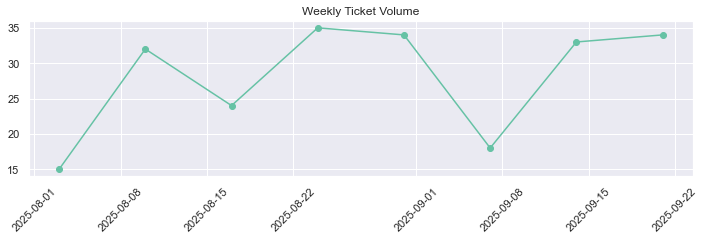

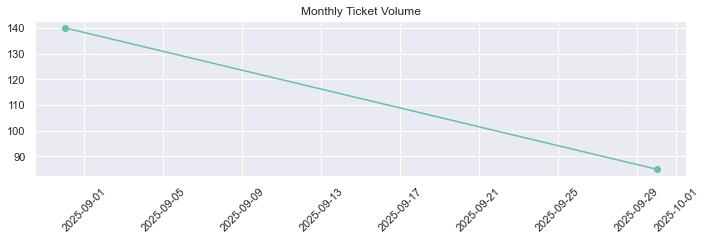

In [21]:
# Cell 12 — Weekly and monthly ticket volume trends (and quick plots)
# Ensure Created DateTime exists
if 'Created DateTime' in df.columns and df['Created DateTime'].notna().any():
    df = df.sort_values('Created DateTime').set_index('Created DateTime')
    weekly = df[ticket_no_col].resample('W').count().rename('tickets').reset_index()
    monthly = df[ticket_no_col].resample('M').count().rename('tickets').reset_index()
    print("Weekly ticket counts (first 10 rows):")
    display(weekly.head(10))
    print("Monthly ticket counts (first 10 rows):")
    display(monthly.head(10))

    # Plot weekly
    plt.figure(figsize=(10,3.5))
    plt.plot(weekly['Created DateTime'], weekly['tickets'], marker='o')
    plt.title("Weekly Ticket Volume")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot monthly
    plt.figure(figsize=(10,3.5))
    plt.plot(monthly['Created DateTime'], monthly['tickets'], marker='o')
    plt.title("Monthly Ticket Volume")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # reset index back to normal if needed
    df = df.reset_index()
else:
    print("Created DateTime column not present or fully missing.")


In [22]:
# Cell 13 — Core KPI calculations for the dashboard scorecard
total_tickets = int(df[ticket_no_col].count())
median_resolution_days = round(df['Resolution Days'].median(skipna=True), 2)

# SLA: % resolved within 48 hours (48 hours = 2 days)
df_resolved_for_sla = df[df['Resolution Hours'].notna()]
if len(df_resolved_for_sla) > 0:
    pct_within_48h = round((df_resolved_for_sla['Resolution Hours'] <= 48).sum() / len(df_resolved_for_sla) * 100, 1)
else:
    pct_within_48h = np.nan

# Top 3 issue share of voice
top_3_issues = df[issue_col].value_counts().nlargest(3).index.tolist()
top_3_count = df[df[issue_col].isin(top_3_issues)][ticket_no_col].count()
top_3_share = round(top_3_count / total_tickets * 100, 1) if total_tickets>0 else np.nan

print("Core KPI Metrics:")
print("1. Total Ticket Volume:", total_tickets)
print("2. Median Resolution Time (days):", median_resolution_days)
print("3. % Tickets Resolved within 48 hours:", pct_within_48h, "%")
print("4. Top 3 issue share of voice:", top_3_share, "%")
print("Top 3 issues:", top_3_issues)


Core KPI Metrics:
1. Total Ticket Volume: 225
2. Median Resolution Time (days): 6.88
3. % Tickets Resolved within 48 hours: 8.2 %
4. Top 3 issue share of voice: 25.8 %
Top 3 issues: ['Looking For Career Guidance (NPS)', 'Applied for jobs but no satisfactory outcome (NPS)', 'False Promise By Sales Team (NPS)']


In [24]:
# Cell 14 — Root-cause extraction from free-text remarks (top unigrams & bigrams)
if remarks_col:
    texts = df[remarks_col].fillna('').astype(str).str.lower().str.replace(r'[^a-z0-9\s]', ' ', regex=True)
    # you can add additional stop words specific to your domain
    extra_stop = ['nps','ticket','issue','feedback','concern','session','program','learner','related','provided']
    vectorizer = CountVectorizer(ngram_range=(1,2), stop_words='english', min_df=2)
    X = vectorizer.fit_transform(texts)
    counts = np.array(X.sum(axis=0)).ravel()
    try:
        terms = vectorizer.get_feature_names_out()
    except AttributeError:  # fallback for older sklearn
        terms = vectorizer.get_feature_names()
    freq_df = pd.DataFrame({'term': terms, 'count': counts}).sort_values('count', ascending=False)
    display(freq_df.head(30))
    # Save to CSV
    freq_df.to_csv("root_cause_phrases.csv", index=False)
    print("Saved root-cause phrases to root_cause_phrases.csv in working directory.")
else:
    print("No remarks/comments column detected — skip root-cause extraction.")


,term,count
1477,resolution,238
1268,placement,54
245,career,51
1377,provided,51
1633,sessions,42
1842,time,42
440,created,38
1163,need,37
418,course,37
1284,pm,35


Saved root-cause phrases to root_cause_phrases.csv in working directory.


In [25]:
# Cell 15 — Save main outputs to CSV for your submission & export plots
os.makedirs("nps_outputs", exist_ok=True)
issue_analysis_freq_sorted.to_csv("nps_outputs/issue_analysis_by_freq.csv", index=False)
issue_analysis_time_sorted.to_csv("nps_outputs/issue_analysis_by_time.csv", index=False)
agent_perf.to_csv("nps_outputs/agent_performance.csv", index=False)

# Save weekly and monthly if available
try:
    weekly.to_csv("nps_outputs/weekly_trend.csv", index=False)
    monthly.to_csv("nps_outputs/monthly_trend.csv", index=False)
except:
    pass

print("Saved CSV outputs in directory: nps_outputs")


Saved CSV outputs in directory: nps_outputs


In [26]:
# Cell 16 — optional: quick dashboard plots saved to files (PNG)
os.makedirs("nps_outputs/plots", exist_ok=True)

# Top issues bar
plt.figure(figsize=(8,4))
issue_counts = df[issue_col].value_counts().nlargest(15)
issue_counts.plot(kind='bar')
plt.title("Top Issue Types")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("nps_outputs/plots/top_issues.png", dpi=150)
plt.close()

# Weekly plot (if exists)
if 'weekly' in globals():
    plt.figure(figsize=(8,3.5))
    plt.plot(weekly['Created DateTime'], weekly['tickets'], marker='o')
    plt.title("Weekly Ticket Volume")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("nps_outputs/plots/weekly_volume.png", dpi=150)
    plt.close()

print("Saved plot images to nps_outputs/plots")


Saved plot images to nps_outputs/plots


In [27]:
# Save SQL queries for automated data quality checks
sql_checks = """
-- Missing critical information
SELECT * FROM nps_data WHERE date IS NULL OR assigned_to IS NULL OR status IS NULL;

-- Logical inconsistencies: Closed tickets with null resolution
SELECT * FROM nps_data WHERE status = 'Closed' AND resolution IS NULL;

-- Duplicates: Check by ticket_id
SELECT ticket_id, COUNT(*) 
FROM nps_data 
GROUP BY ticket_id 
HAVING COUNT(*) > 1;
"""

with open("nps_outputs/data_quality_checks.sql", "w") as f:
    f.write(sql_checks)

print("✅ Data quality SQL checks saved to nps_outputs/data_quality_checks.sql")


✅ Data quality SQL checks saved to nps_outputs/data_quality_checks.sql


In [29]:
!pip install reportlab


  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0


In [31]:
from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Paragraph
from reportlab.lib.styles import getSampleStyleSheet

framework_text = """
# Monitoring Framework & Dashboard Concept

## Root Cause Analysis
- Top 3 Issues identified from remarks & ticket categories
- Systemic vs isolated problems mapped
- Preventive measures suggested for recurring issues

## KPI Dashboard Design
**Metrics to track weekly/monthly**
- Ticket volume by program
- SLA compliance rate
- Resolution efficiency by team
- Top issue categories (frequency + impact)
- Repeat issues % vs first-time issues

**Dashboard Stakeholders**
- Program Managers -> Monthly reviews
- Operations -> Weekly SLA checks
- Leadership -> Quarterly trends

**Escalation**
- Critical tickets unresolved in >7 days -> Escalate to Ops Head
- SLA compliance <85% -> Trigger leadership review

## Resource Optimisation & Review Process
- Automate duplicate detection & SLA monitoring
- Review frequency:
  - Weekly: Ops team
  - Monthly: Program Managers
  - Quarterly: Leadership
- Feedback loops for systemic issue resolution
"""

# ✅ Save as Markdown with UTF-8 encoding
with open("nps_outputs/Monitoring_Framework_and_Dashboard.md", "w", encoding="utf-8") as f:
    f.write(framework_text)

# ✅ Save as PDF
doc = SimpleDocTemplate("nps_outputs/Monitoring_Framework_and_Dashboard.pdf", pagesize=A4)
styles = getSampleStyleSheet()
story = [Paragraph(line, styles['Normal']) for line in framework_text.split("\n") if line.strip()]
doc.build(story)

print("✅ Monitoring Framework saved as both .md and .pdf in nps_outputs/")


✅ Monitoring Framework saved as both .md and .pdf in nps_outputs/


In [35]:
import matplotlib.pyplot as plt

# --- Weekly Ticket Volume ---
weekly_volume = df.groupby(pd.Grouper(key="Created DateTime", freq="W"))["Ticket No"].count()
plt.figure(figsize=(8,5))
weekly_volume.plot(kind="line", marker="o", title="Weekly Ticket Volume")
plt.ylabel("Tickets")
plt.tight_layout()
plt.savefig("nps_outputs/weekly_volume.png")
plt.close()

# --- Monthly Ticket Volume ---
monthly_volume = df.groupby(pd.Grouper(key="Created DateTime", freq="M"))["Ticket No"].count()
plt.figure(figsize=(8,5))
monthly_volume.plot(kind="bar", title="Monthly Ticket Volume")
plt.ylabel("Tickets")
plt.tight_layout()
plt.savefig("nps_outputs/monthly_volume.png")
plt.close()

# --- Top Issues ---
top_issues = df["Issue 2-NPS"].value_counts().head(10)
plt.figure(figsize=(8,5))
top_issues.plot(kind="bar", title="Top 10 Issues")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("nps_outputs/top_issues.png")
plt.close()

print("✅ Charts re-generated and saved in nps_outputs/")


✅ Charts re-generated and saved in nps_outputs/


In [36]:
import os
import matplotlib.pyplot as plt
import pandas as pd

# Create folder if it doesn't exist
os.makedirs("nps_outputs", exist_ok=True)

# --- Ensure your date column is datetime ---
df['Created DateTime'] = pd.to_datetime(df['Created DateTime'])

# --- Weekly Ticket Volume ---
weekly_volume = df.groupby(pd.Grouper(key="Created DateTime", freq="W"))["Ticket No"].count()
plt.figure(figsize=(8,5))
weekly_volume.plot(kind="line", marker="o", title="Weekly Ticket Volume")
plt.ylabel("Tickets")
plt.tight_layout()
plt.savefig("nps_outputs/weekly_volume.png")
plt.close()

# --- Monthly Ticket Volume ---
monthly_volume = df.groupby(pd.Grouper(key="Created DateTime", freq="M"))["Ticket No"].count()
plt.figure(figsize=(8,5))
monthly_volume.plot(kind="bar", title="Monthly Ticket Volume")
plt.ylabel("Tickets")
plt.tight_layout()
plt.savefig("nps_outputs/monthly_volume.png")
plt.close()

# --- Top Issues ---
top_issues = df["Issue 2-NPS"].value_counts().head(10)
plt.figure(figsize=(8,5))
top_issues.plot(kind="bar", title="Top 10 Issues")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("nps_outputs/top_issues.png")
plt.close()

print("✅ Charts re-generated and saved in nps_outputs/")


✅ Charts re-generated and saved in nps_outputs/


In [37]:
import os
print(os.getcwd())


C:\Users\subhashini


In [38]:
import os
os.startfile("nps_outputs")


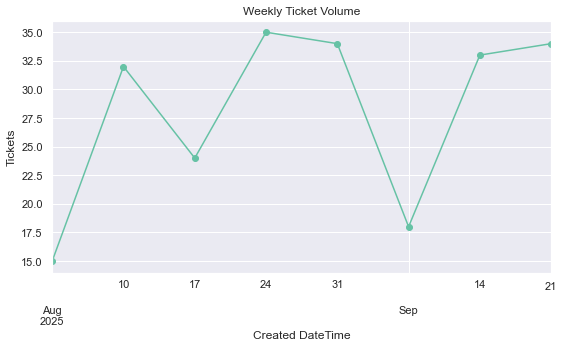

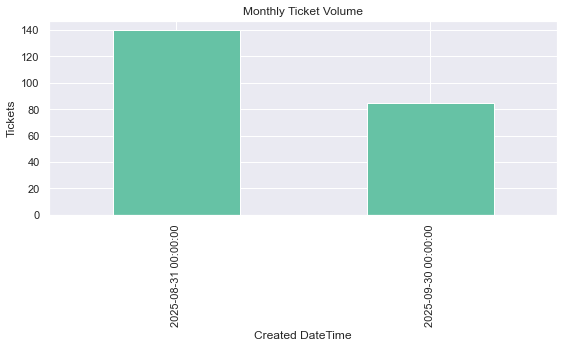

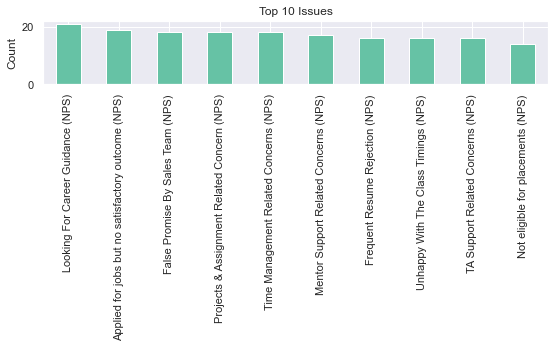

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime
df['Created DateTime'] = pd.to_datetime(df['Created DateTime'])

# --- Weekly Ticket Volume ---
weekly_volume = df.groupby(pd.Grouper(key="Created DateTime", freq="W"))["Ticket No"].count()
plt.figure(figsize=(8,5))
weekly_volume.plot(kind="line", marker="o", title="Weekly Ticket Volume")
plt.ylabel("Tickets")
plt.tight_layout()
plt.show()   # <-- display in notebook

# --- Monthly Ticket Volume ---
monthly_volume = df.groupby(pd.Grouper(key="Created DateTime", freq="M"))["Ticket No"].count()
plt.figure(figsize=(8,5))
monthly_volume.plot(kind="bar", title="Monthly Ticket Volume")
plt.ylabel("Tickets")
plt.tight_layout()
plt.show()   # <-- display in notebook

# --- Top Issues ---
top_issues = df["Issue 2-NPS"].value_counts().head(10)
plt.figure(figsize=(8,5))
top_issues.plot(kind="bar", title="Top 10 Issues")
plt.ylabel("Count")
plt.tight_layout()
plt.show()   # <-- display in notebook


In [40]:
import os
os.startfile("nps_outputs")
